### Examples

### Normally I would run the cell for few more times to make sure the GPU is warmed up

In [ ]:
# gpu_info
from qgear.core import get_gpu_info
gpu_info = get_gpu_info(verb=2)

0  NVIDIA A100-PCIE-40GB   bus_id: 00000000:C3:00.0
Total Memory: 40960.00 MB
Used Memory: 14928.44 MB
Free Memory: 26031.56 MB



In [ ]:
import os
import numpy as np
from time import time
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
from qgear.toolbox.Util_CudaQ import qiskit_to_gateList, counts_cudaq_to_qiskit
from qgear.toolbox.Util_H5io4 import write4_data_hdf5, read4_data_hdf5
from qgear.runner import run_cudaq
# ----------------------------
# 1. Create a simple Qiskit circuit
n_qubits = 25
qc = QuantumCircuit(n_qubits)
qc.h(0)
qc.cx(0, 1)
qc.ry(np.pi/4, 2)
qc.u(np.pi/2, np.pi/4, np.pi/8, 3)
qc.measure_all()

qcEL = [qc]  # List of circuits
numShots = 10000
verb = 0
# backend_cudaq = "qpp-cpu"  # safer default for CPU-only systems
backend_cudaq="nvidia"
# ----------------------------
# 2. Run with CUDA-Q
out_path = "out"
os.makedirs(out_path, exist_ok=True)
circ_name = "toy_example"

# Convert to gate list
outD, md = qiskit_to_gateList(qcEL)
inpF = os.path.join(out_path, circ_name + ".gate_list.h5")
md["short_name"] = circ_name
write4_data_hdf5(outD, inpF, md)

# Load back
gateD, MD = read4_data_hdf5(inpF, verb)
# Time CUDA-Q execution
T0 = time()
resL_cudaq = run_cudaq(gateD, numShots, verb=verb, backend=backend_cudaq)
resL_cudaq = counts_cudaq_to_qiskit(resL_cudaq[0])
ela_cudaq = time() - T0

# ----------------------------
# 3. Run with Qiskit AerSimulator
aer_backend = AerSimulator()

# Transpile for Aer
qcT = transpile(qc, aer_backend)

T1 = time()
job = aer_backend.run(qcT, shots=numShots)
res_aer = job.result().get_counts()
ela_aer = time() - T1

# ----------------------------
# 4. Print results
print("=== CUDA-Q Results ===")
print(f"Execution time: {ela_cudaq:.4f} s")
print(f"Counts: {resL_cudaq[0]}")

print("\n=== Qiskit Aer Results ===")
print(f"Execution time: {ela_aer:.4f} s")
print(f"Counts: {res_aer}")

# ----------------------------
# 5. Compare times
speedup = ela_aer / ela_cudaq if ela_cudaq > 0 else float('inf')
print(f"\nSpeedup (Aer / CUDA-Q): {speedup:.2f}x faster with CUDA-Q" if speedup > 1 else f"CUDA-Q is slower by {1/speedup:.2f}x")

qiskit_to_gateList: nGate 30
saving data as hdf5: out/toy_example.gate_list.h5
h5-write : circ_type (1, 2) int32
h5-write : gate_type (1, 30, 3) int32
h5-write : gate_param (1, 30, 3) float32
h5-write : meta.JSON as string (1,) object
closed  hdf5: out/toy_example.gate_list.h5  size=0.01 MB, elaT=0.0 sec
=== CUDA-Q Results ===
Execution time: 0.0158 s
Counts: {'0000000000000000000000000': 2171, '0000000000000000000001000': 2187, '0000000000000000000000100': 363, '0000000000000000000001100': 346, '0000000000000000000000011': 2131, '0000000000000000000001011': 2090, '0000000000000000000000111': 356, '0000000000000000000001111': 356}

=== Qiskit Aer Results ===
Execution time: 0.4330 s
Counts: {'0000000000000000000000100': 369, '0000000000000000000001111': 354, '0000000000000000000000111': 345, '0000000000000000000000011': 2170, '0000000000000000000001011': 2122, '0000000000000000000000000': 2160, '0000000000000000000001100': 385, '0000000000000000000001000': 2095}

Speedup (Aer / CUDA-Q)

## QFT Speed up

/tmp/ipykernel_657/378558003.py:19: DeprecationWarning: The class ``qiskit.circuit.library.basis_change.qft.QFT`` is deprecated as of Qiskit 2.1. It will be removed in Qiskit 3.0. ('Use qiskit.circuit.library.QFTGate or qiskit.synthesis.qft.synth_qft_full instead, for access to all previous arguments.',)
  qc = QFT(num_qubits=n_qubits, do_swaps=False).decompose()


qiskit_to_gateList: nGate 10
saving data as hdf5: out/qft_3q.gate_list.h5
h5-write : circ_type (1, 2) int32
h5-write : gate_type (1, 10, 3) int32
h5-write : gate_param (1, 10, 3) float32
h5-write : meta.JSON as string (1,) object
closed  hdf5: out/qft_3q.gate_list.h5  size=0.01 MB, elaT=0.0 sec
read data from hdf5: out/qft_3q.gate_list.h5
read obj: circ_type (1, 2) int32
read obj: gate_param (1, 10, 3) float32
read obj: gate_type (1, 10, 3) int32
read str: meta.JSON 1 <class 'numpy.ndarray'>
 done h5, num rec:3  elaT=0.0 sec
                            ╭────────────╮╭───────────╮╭───╮
q0 : ───────────────────────┤ r1(0.7854) ├┤ r1(1.571) ├┤ h ├
          ╭───────────╮╭───╮╰─────┬──────╯╰─────┬─────╯╰───╯
q1 : ─────┤ r1(1.571) ├┤ h ├──────┼─────────────●───────────
     ╭───╮╰─────┬─────╯╰───╯      │                         
q2 : ┤ h ├──────●─────────────────●─────────────────────────
     ╰───╯                                                  

Statevector fidelity: 0.9999999657714577


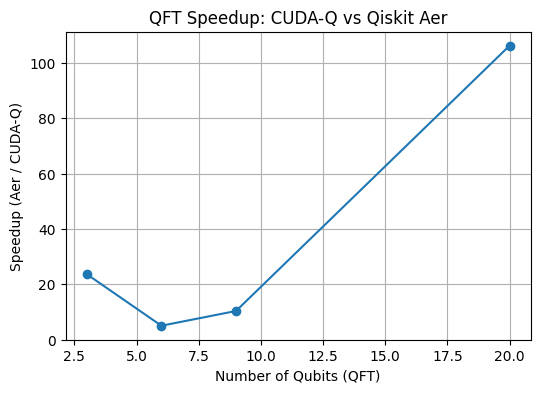

In [ ]:
import os
import numpy as np
from time import time
from qiskit import QuantumCircuit, transpile
from qiskit.circuit.library import QFT
from qiskit_aer import AerSimulator
from qgear.toolbox.Util_CudaQ import qiskit_to_gateList
from qgear.runner import run_cudaq
from qgear.toolbox.Util_H5io4 import write4_data_hdf5, read4_data_hdf5
from qiskit.quantum_info import Statevector
from qiskit_aer import StatevectorSimulator

def benchmark_qft(n_qubits=5, numShots=1000, backend_cudaq="nvidia", verb=0):
    """
    Compare CUDA-Q vs Qiskit Aer for QFT circuit.
    """
    # ----------------------------
    # 1. Create QFT circuit
    qc = QFT(num_qubits=n_qubits, do_swaps=False).decompose()
    sv_qiskit = Statevector(qc)
    qc.measure_all()
    qcEL = [qc]
    # print("\n--- Qiskit Circuit ---")
    # print(qc.draw("text"))
    
    # ----------------------------
    # 2. CUDA-Q path
    out_path = "out"
    os.makedirs(out_path, exist_ok=True)
    circ_name = f"qft_{n_qubits}q"

    gateD, md = qiskit_to_gateList(qcEL)
   
    # dont save for now
    inpF = os.path.join(out_path, circ_name + ".gate_list.h5")
    md["short_name"] = circ_name
    write4_data_hdf5(gateD, inpF, md)

    gateD, MD = read4_data_hdf5(inpF, verb)
    T0 = time()
    resL_cudaq,stateL = run_cudaq(gateD, numShots, verb=verb, backend=backend_cudaq)
    sv_cudaq = stateL[0]
    resL_cudaq = counts_cudaq_to_qiskit(resL_cudaq)
    # Fidelity check

    # print(resL_cudaq[0])
    ela_cudaq = time() - T0

    # ----------------------------
    # 3. Qiskit Aer path
    aer_backend = AerSimulator()
    qcT = transpile(qc, aer_backend)

    T1 = time()
    job = aer_backend.run(qcT, shots=numShots)
    res_aer = job.result().get_counts()
    fidelity = abs(np.vdot(sv_qiskit, np.array(sv_cudaq)))**2
    print("Statevector fidelity:", fidelity)
    # print(res_aer)
    ela_aer = time() - T1

    # ----------------------------
    # 4. Report
    print(f"\n=== QFT {n_qubits} qubits ===")
    print(f"CUDA-Q ({backend_cudaq}): {ela_cudaq:.4f} s")
    print(f"AerSimulator: {ela_aer:.4f} s")
    speedup = ela_aer / ela_cudaq if ela_cudaq > 0 else float('inf')
    print(f"Speedup (Aer / CUDA-Q): {speedup:.2f}x" if speedup > 1 else f"CUDA-Q slower by {1/speedup:.2f}x")

    return ela_cudaq, ela_aer

# ----------------------------
# Run benchmarks for increasing QFT sizes
results = []
for nq in [3, 6, 9, 20]:
    results.append((nq, *benchmark_qft(n_qubits=nq, numShots=2000, backend_cudaq="nvidia", verb=1)))

# ----------------------------
# Optional: Plot speedup
import matplotlib.pyplot as plt

nq_list = [r[0] for r in results]
cudaq_times = [r[1] for r in results]
aer_times = [r[2] for r in results]
speedups = [a/b for a, b in zip(aer_times, cudaq_times)]

plt.figure(figsize=(6,4))
plt.plot(nq_list, speedups, marker='o')
plt.xlabel("Number of Qubits (QFT)")
plt.ylabel("Speedup (Aer / CUDA-Q)")
plt.title("QFT Speedup: CUDA-Q vs Qiskit Aer")
plt.grid(True)
plt.show()